In [3]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd 
import csv 
import json 

def read_csv(path):
    all_data = []
    with open(path) as f1:
        reader = csv.DictReader(f1)
        for row in reader:
            data = {}
            for k, v in row.items():
                try:
                    v = json.loads(v)
                except json.JSONDecodeError:
                    v = v
                data[k] = v
            all_data.append(data)
    return all_data



In [13]:
data = read_csv('output.csv') + read_csv("from_ann_output.csv")

count_ambig = 0
ambig_counts = {"+d +a": {"ambiguous": [], "non-ambiguous": []},
                "-d +a": {"ambiguous": [], "non-ambiguous": []},
                "+d -a": {"ambiguous": [], "non-ambiguous": []},
                "-d -a": {"ambiguous": [], "non-ambiguous": []}} 

count_p_r_ratio = []
dyn_agent_data = json.load(open("dynamic_agentive.json")) + json.load(open("from_ann_dynamic_agentive.json"))

def get_da_class(row):
    if 'is_dynamic' not in row:
        return None
    elif row['is_dynamic'] == 'y' and row['is_agentive'] == 'y': 
        return '+d +a'
    elif row['is_dynamic'] == 'n' and row['is_agentive'] == 'y': 
        return '-d +a'
    elif row['is_dynamic'] == 'y' and row['is_agentive'] == 'n': 
        return '+d -a'
    elif row['is_dynamic'] == 'n' and row['is_agentive'] == 'n': 
        return '-d -a'
    else:
        raise ValueError(f"Unknown code: {row['is_dynamic']} {row['is_agentive']}")

total = 0 
skipped = 0
for i, row in enumerate(data):
    try:
        da_row = dyn_agent_data[i]
    except IndexError:
        print(f"{i} {len(dyn_agent_data)} {len(data)}")
        continue
    
    da_key = get_da_class(da_row)
    if da_key is None:
        skipped += 1
        continue
    total += 1
    try:
        classes = row['answerQuestions']
    except KeyError:
        classes = row['Answer.answer_questions']
    if len(classes) > 1 and 'p' in classes and 'r' in classes:
        count_ambig += 1

        answers = row['Answer.answer_groups']

        p_r_count = {'p': 0, 'r': 0}
        for i, c in enumerate(classes):
            ans = answers[i]
            for a in ans:
                try:
                    p_r_count[c] += 1
                except KeyError:
                    pass
        ambig_counts[da_key]['ambiguous'].append(i)
        count_p_r_ratio.append(p_r_count)
    else:
        ambig_counts[da_key]['non-ambiguous'].append(i)

print(f"total: {total}, skipped: {skipped} ")


126 126 127
total: 117, skipped: 9 


In [14]:
df_to_plot = []

for k,v in ambig_counts.items():
    print(f"{k}")
    for k1, v1 in v.items():
        print(f"\t{k1}: {len(v1)}")
        df_to_plot.append({"key": k, "type": k1, "count": len(v1)})

df_to_plot = pd.DataFrame(df_to_plot)
print(df_to_plot.head())

+d +a
	ambiguous: 0
	non-ambiguous: 23
-d +a
	ambiguous: 1
	non-ambiguous: 8
+d -a
	ambiguous: 1
	non-ambiguous: 10
-d -a
	ambiguous: 3
	non-ambiguous: 71
     key           type  count
0  +d +a      ambiguous      0
1  +d +a  non-ambiguous     23
2  -d +a      ambiguous      1
3  -d +a  non-ambiguous      8
4  +d -a      ambiguous      1


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Elias/papers/vqa-ambiguity-2022/figures/why_count.pdf'

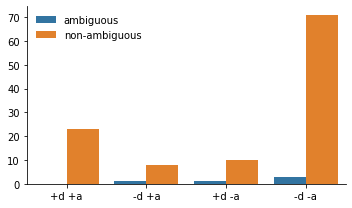

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.barplot(data=df_to_plot, x = 'key', hue = 'type', y='count', ax=ax)
sns.despine()
ax.legend(frameon=False)
ax.set_ylabel("")
ax.set_xlabel("")

plt.tight_layout()
plt.savefig("/home/estengel/papers/vqa-ambiguity-2022/figures/why_count.pdf")